In [1]:
from importlib import reload
import LambdaRankHW
import numpy as np
import query
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/Dana/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpi_12wu4w/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/Dana/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.5.2-64/tmpi_12wu4w/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce 940MX (CNMeM is enabled with initial size: 80.0% of memory, CuDNN 5110)
C:\Users\Dana\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your CuDNN version is more recent then Theano. If you see problems, try updating Theano or downgrading CuDNN to version 4.
  warnings.warn(warn)
C:\Users\Dana\Anaconda3\lib\site-packages\theano\tensor\signal\do

In [2]:
# Runs a full experiment on one model with the given setup, reports test ndcgs and pickles the results
def full_experiment(n_epochs, model_type, num_features, num_folds, save_models):

    results, best_ranker = LambdaRankHW.experiment(n_epochs, model_type, num_features, num_folds)

    print('Loading all test queries')
    test_queries = {}
    for fold in range(1,6):
        test_queries = {**test_queries, **query.load_queries(os.path.normpath('./HP2003/Fold%d/test.txt' % fold), num_features)}


    print('Running test mndcg')
    test_results= LambdaRankHW.report_test_ndcg(best_ranker, test_queries)
    print('Test mNDCG: %f' % (sum(list(test_results.values()))/len(test_queries)))

    if save_models:
        with open('./results_%s_epochs%s_kfold%s' % (measure_type, n_epochs, num_folds), 'wb') as f:
            pickle.dump(results, f)
            pickle.dump(test_results,f)
        
    data = []

    for fold in range(1,len(results)+1):
        for e_num in range(n_epochs):
            for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
                epoch_dict = results[fold-1][e_num]
                aux = [e_num + 1, fold, measure, epoch_dict[measure]]
                data.append(aux)

    df = pd.DataFrame(data, columns=['Epoch', 'Fold', 'Measure', 'Value'])

    return df

In [3]:
# Superior plots
def plot_results(df, measure_type, save_plots):
    ls = []
    for i in range(n_epochs):
        if i%50 == 0:
            ls.append(i)
        else:
            ls.append('')

    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    for measure in ['train_loss', 'train_mndcg', 'val_mndcg']:
        ax = sns.pointplot(x="Epoch", y="Value", hue="Fold", data=df.loc[df['Measure'] == measure], ci=None)
        if  measure == 'train_loss':
            ax.set(ylabel='Utility')
        else:
            ax.set(ylabel=measure)
        ax.set_xticklabels(ls)
        #ax.set(xticklabels=[i*10 for i in range(int(n_epochs/10))])
        if save_plots:
            plt.savefig('./%s_%s.png' % (measure_type, measure))
        plt.show()

    plt.figure()
    ax = sns.pointplot(x="Epoch", y="Value", hue='Measure',
                  data=df.loc[df['Measure'].isin(['train_mndcg', 'val_mndcg'])], ci=95)
    ax.set_xticklabels(ls)
    if save_plots:
        plt.savefig('./%s_%s.png' % (measure_type, 'mean_train_val'))
    plt.show()

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 200 took 0.244s
training loss:		0.009528
training mNDCG:		0.166879
Lambda Count 0
validation mNDCG:		0.202096

Epoch 100 of 200 took 23.361s
training loss:		0.001176
training mNDCG:		0.796830
Lambda Count 0
validation mNDCG:		0.707136

Epoch 200 of 200 took 23.947s
training loss:		0.000923
training mNDCG:		0.827456
Lambda Count 0
validation mNDCG:		0.709068

Loading train queries
Loading val queries
Creating the S Matrix
input_dim 64 output_dim 1
finished create_iter_functions
Epoch 1 of 200 took 0.243s
training loss:		0.009505
training mNDCG:		0.448023
Lambda Count 0
validation mNDCG:		0.511976

Epoch 100 of 200 took 24.156s
training loss:		0.001324
training mNDCG:		0.762516
Lambda Count 0
validation mNDCG:		0.714794

Epoch 200 of 200 took 23.597s
training loss:		0.001100
training mNDCG:		0.774849
Lambda Count 0
validation mNDCG:		0.701701

Loading train 

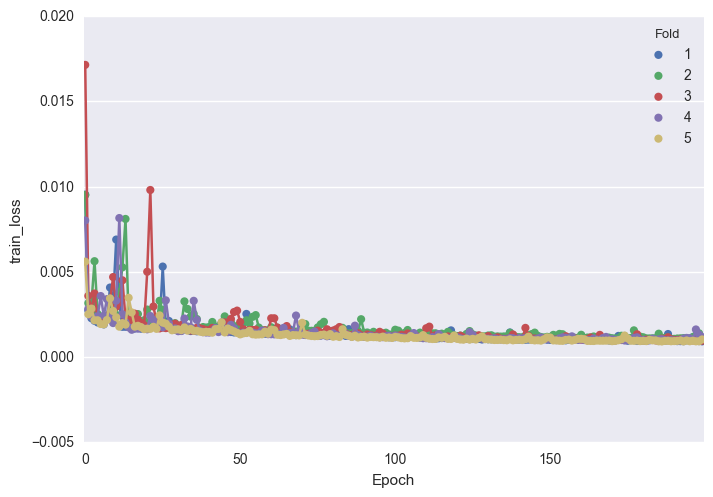

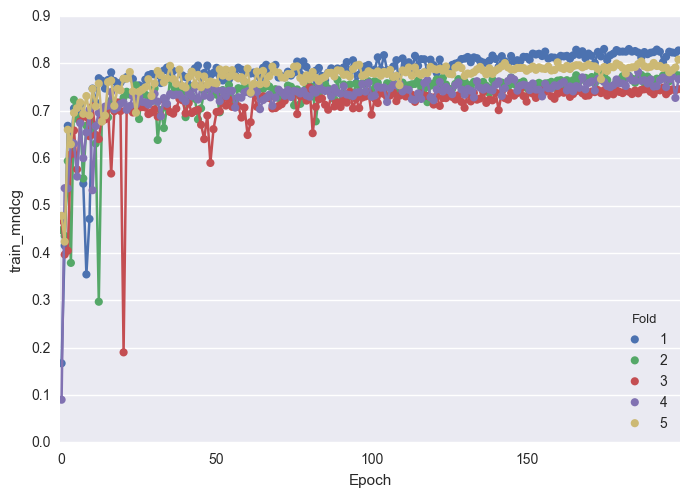

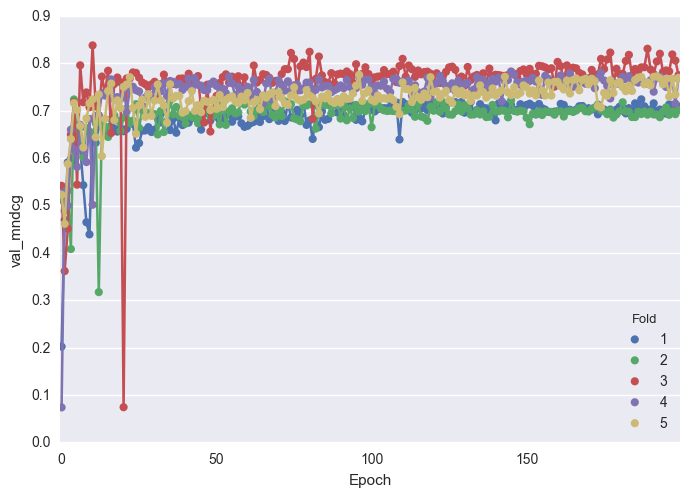

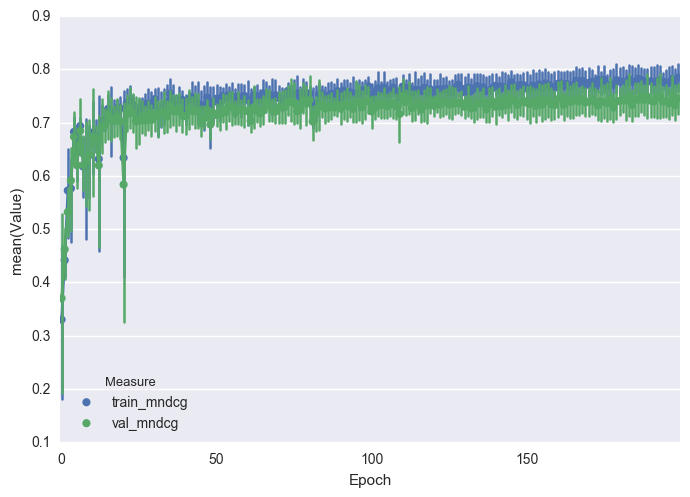

In [7]:
# run everything
n_epochs = 200
types = [LambdaRankHW.POINTWISE]
num_features = 64
num_folds = 5
save_models = True
save_plots = True

for model_type in types:
    df = full_experiment(n_epochs, model_type, num_features, num_folds, save_models)
    plot_results(df, model_type, save_plots)
